In [1]:
# Импорты
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Настройки отображения
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [13]:
# координаты в Казани Тц Парк Хаус
latitude = 55.828563
longitude = 49.116042
start_date = "2025-07-01"
end_date = "2025-07-31"

url = (
    f"https://api.open-meteo.com/v1/forecast"
    f"?latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly=temperature_2m,precipitation"
)

response = requests.get(url)
data = response.json()

df = pd.DataFrame({
    'time': data['hourly']['time'],
    'temperature': data['hourly']['temperature_2m'],
    'precipitation': data['hourly']['precipitation']
})

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.head()


,temperature,precipitation
time,,
2025-07-01 00:00:00,12.7,0.0
2025-07-01 01:00:00,12.5,0.0
2025-07-01 02:00:00,13.2,0.0
2025-07-01 03:00:00,14.7,0.0
2025-07-01 04:00:00,16.5,0.0


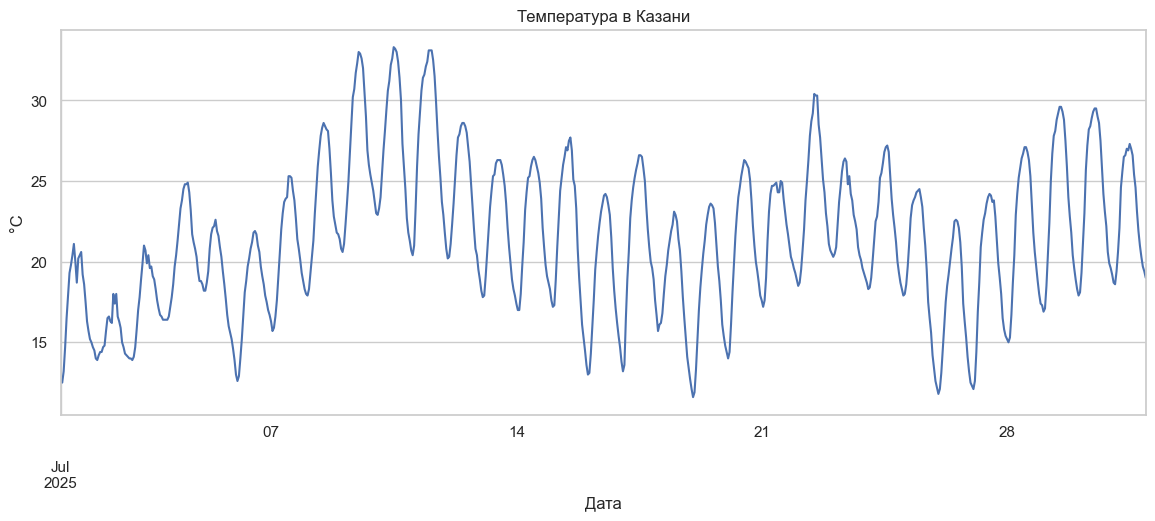

In [14]:
# График температуры
plt.figure(figsize=(14, 5))
df['temperature'].plot()
plt.title('Температура в Казани')
plt.ylabel('°C')
plt.xlabel('Дата')
plt.grid(True)
plt.show()

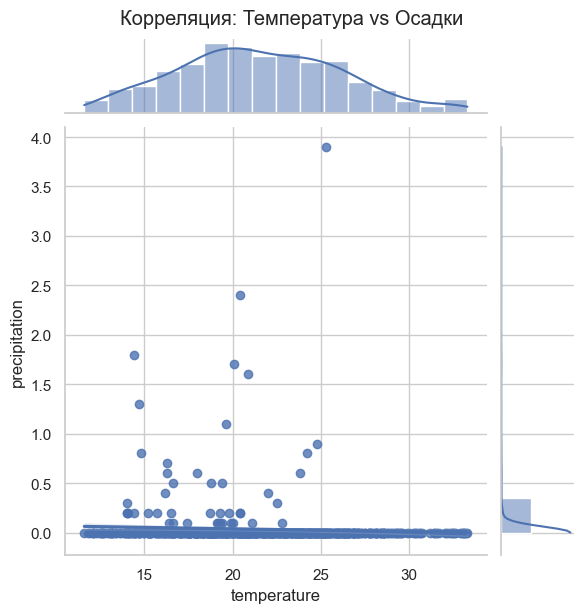

In [15]:
# Корреляция между температурой и осадками
sns.jointplot(x='temperature', y='precipitation', data=df, kind='reg', height=6)
plt.suptitle('Корреляция: Температура vs Осадки', y=1.02)
plt.show()


Корреляция между температурой и осадками: -0.06


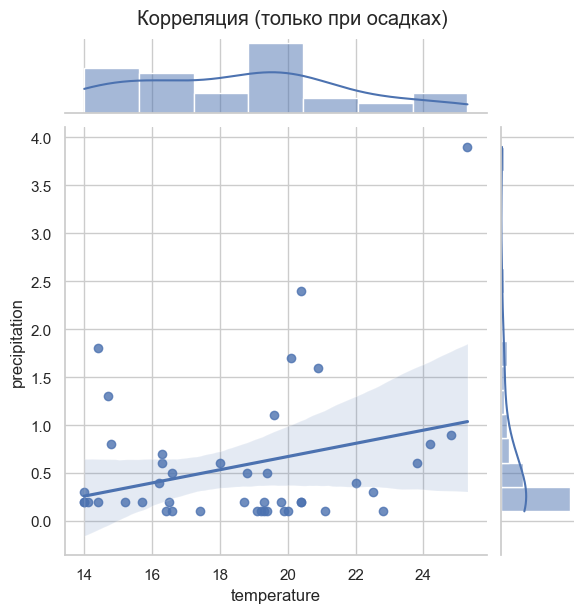

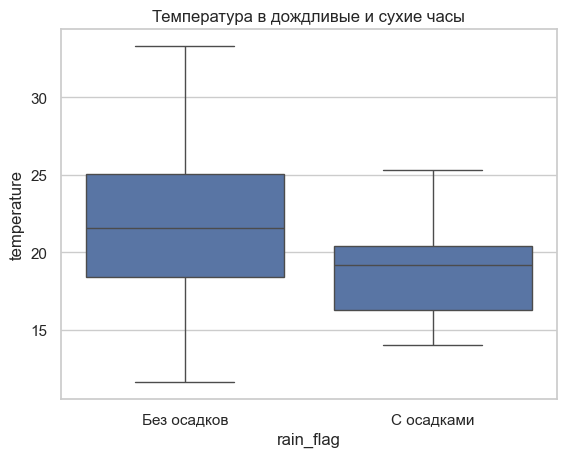

In [20]:
corr = df[['temperature', 'precipitation']].corr().iloc[0,1]
print(f"Корреляция между температурой и осадками: {corr:.2f}")

df_rain = df[df['precipitation'] > 0]
sns.jointplot(x='temperature', y='precipitation', data=df_rain, kind='reg')
plt.suptitle('Корреляция (только при осадках)', y=1.02)
plt.show()

df['rain_flag'] = df['precipitation'] > 0
sns.boxplot(x='rain_flag', y='temperature', data=df)
plt.xticks([0,1], ['Без осадков', 'С осадками'])
plt.title('Температура в дождливые и сухие часы')
plt.show()

In [21]:
df_rain = df[df['precipitation'] > 0]
corr_rain = df_rain[['temperature', 'precipitation']].corr().iloc[0,1]
print(f"Корреляция при осадках: {corr_rain:.2f}")


Корреляция при осадках: 0.29


In [22]:
# Категориальный анализ
df['rain_flag'] = df['precipitation'] > 0
df.groupby('rain_flag')['temperature'].describe()

,count,mean,std,min,25%,50%,75%,max
rain_flag,,,,,,,,
False,700.0,21.734286,4.670973,11.6,18.400,21.55,25.025,33.3
True,44.0,18.563636,3.135030,14.0,16.275,19.15,20.400,25.3


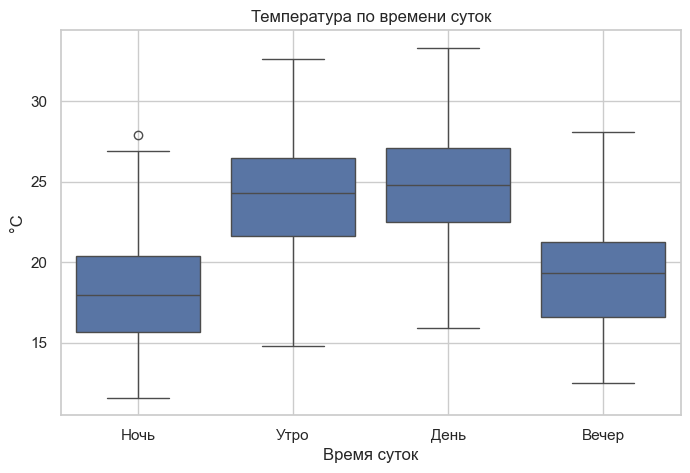

In [16]:
# Классификация времени суток
def time_of_day(hour):
    if 6 <= hour < 12:
        return "Утро"
    elif 12 <= hour < 18:
        return "День"
    elif 18 <= hour < 24:
        return "Вечер"
    else:
        return "Ночь"

df['hour'] = df.index.hour
df['timeofday'] = df['hour'].apply(time_of_day)

plt.figure(figsize=(8, 5))
sns.boxplot(x='timeofday', y='temperature', data=df, order=["Ночь", "Утро", "День", "Вечер"])
plt.title("Температура по времени суток")
plt.xlabel("Время суток")
plt.ylabel("°C")
plt.grid(True)
plt.show()


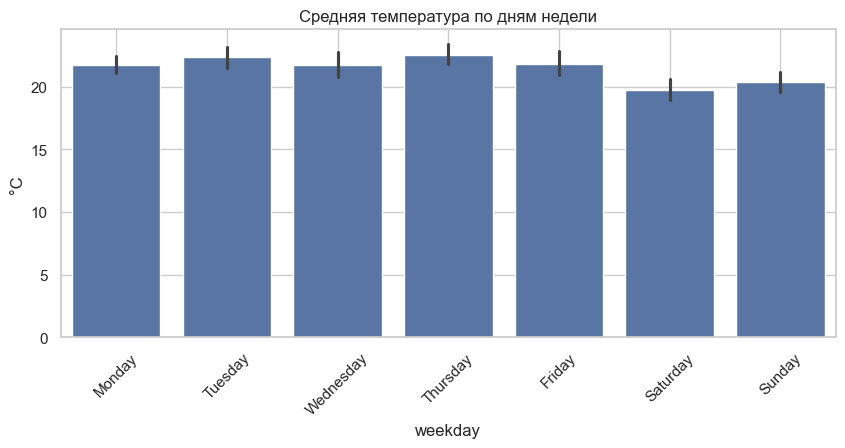

In [17]:
df['weekday'] = df.index.day_name()
df['day'] = df.index.day
df['month'] = df.index.month

# Средняя температура по дню недели
plt.figure(figsize=(10, 4))
sns.barplot(x='weekday', y='temperature', data=df, estimator='mean', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title("Средняя температура по дням недели")
plt.xticks(rotation=45)
plt.ylabel("°C")
plt.grid(True)
plt.show()


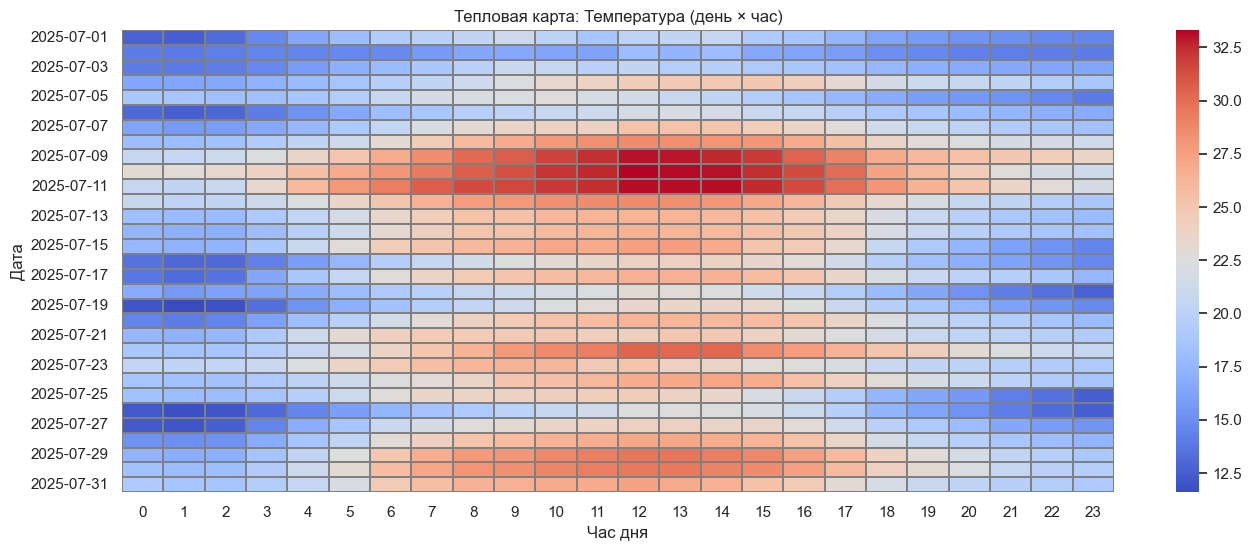

In [18]:
pivot = df.reset_index().pivot_table(index=df.index.date, columns='hour', values='temperature')

plt.figure(figsize=(16, 6))
sns.heatmap(pivot, cmap='coolwarm', linewidths=0.2, linecolor='gray')
plt.title("Тепловая карта: Температура (день × час)")
plt.xlabel("Час дня")
plt.ylabel("Дата")
plt.show()


# Анализ по сезонам


In [26]:
import pandas as pd
import requests

# Координаты Казани, ТЦ Парк Хаус
latitude = 55.828563
longitude = 49.116042
start_date = "2024-01-01"
end_date = "2024-12-31"

url = (
    f"https://archive-api.open-meteo.com/v1/archive"
    f"?latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly=temperature_2m,precipitation"
    f"&timezone=Europe/Moscow"
)

response = requests.get(url)
data = response.json()

if "hourly" in data:
    df = pd.DataFrame({
        'time': data['hourly']['time'],
        'temperature': data['hourly']['temperature_2m'],
        'precipitation': data['hourly']['precipitation']
    })

    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    display(df.head())
else:
    print(data)


,temperature,precipitation
time,,
2024-01-01 00:00:00,-8.2,0.0
2024-01-01 01:00:00,-8.9,0.0
2024-01-01 02:00:00,-9.6,0.1
2024-01-01 03:00:00,-9.9,0.1
2024-01-01 04:00:00,-10.3,0.2


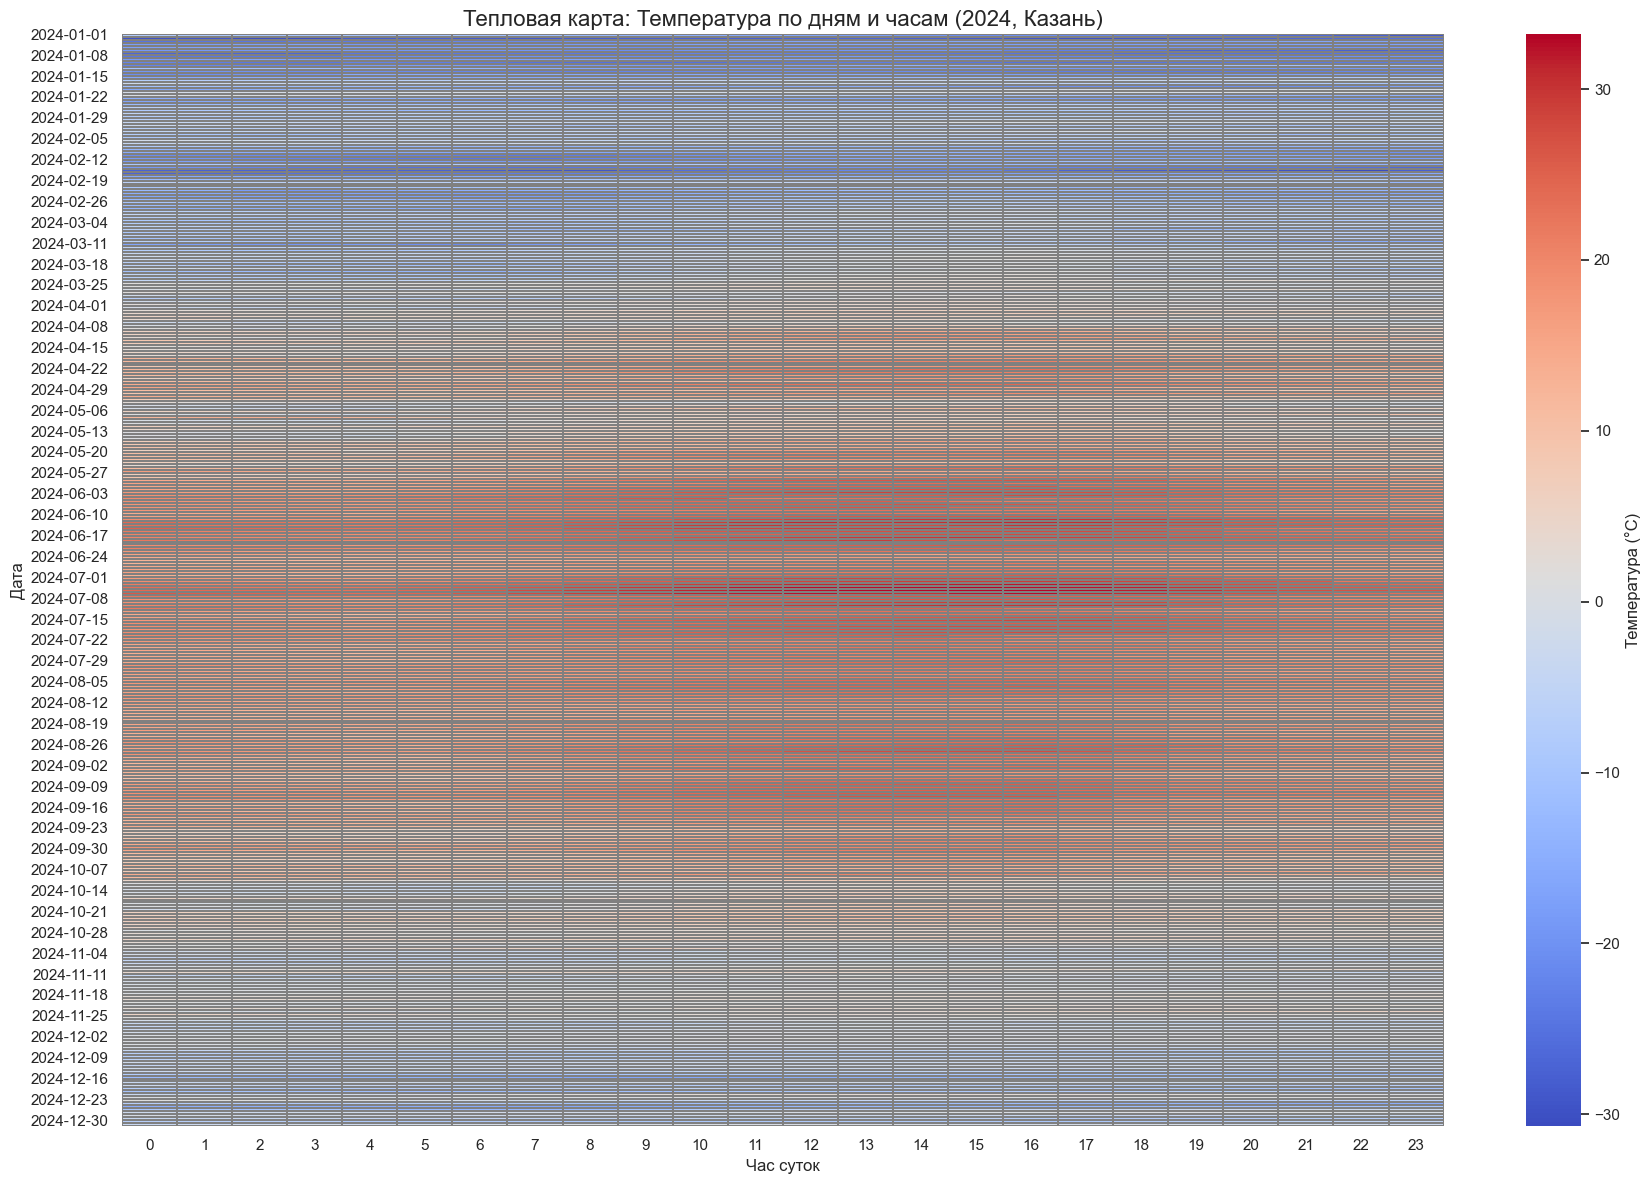

In [28]:
df.index = pd.to_datetime(df.index)

df['date'] = df.index.date
df['hour'] = df.index.hour

pivot = df.pivot_table(index='date', columns='hour', values='temperature')

plt.figure(figsize=(18, 12))
sns.heatmap(pivot, cmap='coolwarm', linewidths=0.1, linecolor='gray', cbar_kws={'label': 'Температура (°C)'})
plt.title("Тепловая карта: Температура по дням и часам (2024, Казань)", fontsize=16)
plt.xlabel("Час суток")
plt.ylabel("Дата")
plt.tight_layout()
plt.show()


Корреляция между температурой и осадками: 0.01


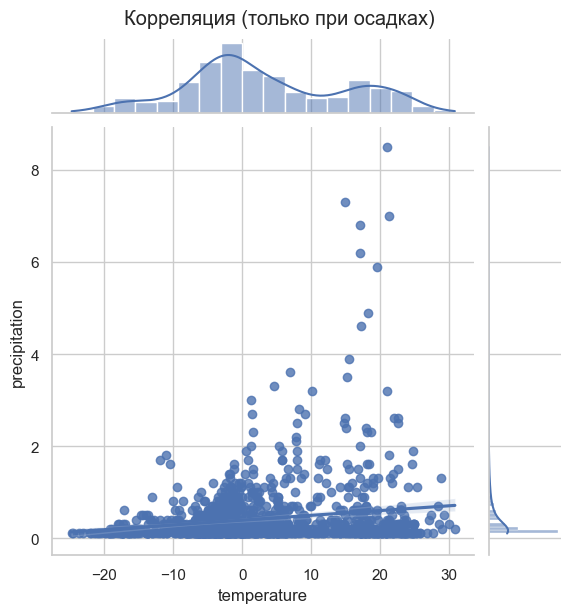

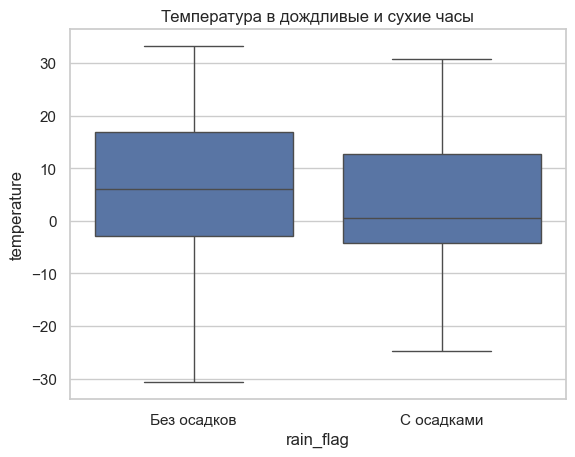

In [29]:
corr = df[['temperature', 'precipitation']].corr().iloc[0,1]
print(f"Корреляция между температурой и осадками: {corr:.2f}")

df_rain = df[df['precipitation'] > 0]
sns.jointplot(x='temperature', y='precipitation', data=df_rain, kind='reg')
plt.suptitle('Корреляция (только при осадках)', y=1.02)
plt.show()

df['rain_flag'] = df['precipitation'] > 0
sns.boxplot(x='rain_flag', y='temperature', data=df)
plt.xticks([0,1], ['Без осадков', 'С осадками'])
plt.title('Температура в дождливые и сухие часы')
plt.show()